In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ctgan import CTGAN
from ctgan import load_demo
import data_describe as dd
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures

In [2]:
data = pd.read_csv('../data/S&P 500 Energy 100-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data

,date,S&P 500,S&P 500 Energy (Sector),S&P 500 Performance (%),S&P 500 Energy (Sector) Performance (%),S&P 500 Energy (Sector) Outperform/Underperform,overall,energy,energy commodities,fuels and utilities,transportation,transportation services,utilities and public transportation
0,1993-01-04,435.38,90.74,-3.982886,-11.239362,UNDERPERFORM,143.100,104.300,100.500,118.900,160.800,160.800,131.800
1,1993-01-05,434.34,90.91,-3.994165,-11.797807,UNDERPERFORM,143.100,104.300,100.500,118.900,160.800,160.800,131.800
2,1993-01-06,434.52,90.89,-3.480753,-11.577002,UNDERPERFORM,143.100,104.300,100.500,118.900,160.800,160.800,131.800
3,1993-01-07,430.73,89.91,-5.090012,-13.239409,UNDERPERFORM,143.100,104.300,100.500,118.900,160.800,160.800,131.800
4,1993-01-08,429.05,88.90,-5.464360,-14.097980,UNDERPERFORM,143.100,104.300,100.500,118.900,160.800,160.800,131.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7280,2021-11-24,4701.46,436.37,5.426902,-28.859290,UNDERPERFORM,280.126,263.553,309.682,272.154,326.397,326.397,233.199
7281,2021-11-26,4594.62,418.74,4.573863,-29.546563,UNDERPERFORM,280.126,263.553,309.682,272.154,326.397,326.397,233.199
7282,2021-11-29,4655.27,421.22,8.977288,-27.363339,UNDERPERFORM,280.126,263.553,309.682,272.154,326.397,326.397,233.199
7283,2021-11-30,4567.00,410.70,6.305224,-26.730059,UNDERPERFORM,280.126,263.553,309.682,272.154,326.397,326.397,233.199


## Using data after 2010 (Best Model)

In [3]:
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2010]
data

,year,month,date,S&P 500,S&P 500 Energy (Sector),S&P 500 Performance (%),S&P 500 Energy (Sector) Performance (%),S&P 500 Energy (Sector) Outperform/Underperform,overall,energy,energy commodities,fuels and utilities,transportation,transportation services,utilities and public transportation,dow
204,2010,1,2010-01-14,1148.46,448.26,8.787618,16.319381,OUTPERFORM,217.281,209.624,239.914,212.638,257.050,257.050,201.045,3
205,2010,2,2010-02-11,1078.47,417.06,1.716544,7.725688,OUTPERFORM,217.353,209.326,237.315,214.506,257.804,257.804,202.330,3
206,2010,3,2010-03-11,1150.24,434.70,2.657837,3.925600,OUTPERFORM,217.403,209.219,237.093,214.821,258.306,258.306,202.917,3
207,2010,4,2010-04-08,1186.44,442.81,13.110628,15.012597,OUTPERFORM,217.290,206.631,232.440,214.303,258.969,258.969,203.124,3
208,2010,5,2010-05-13,1157.44,429.09,-0.285160,-0.181450,OUTPERFORM,217.199,203.764,227.477,213.427,259.454,259.454,203.501,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,2021,7,2021-07-08,4320.82,391.55,-7.184331,-7.043825,OUTPERFORM,273.092,242.958,276.734,262.483,326.470,326.470,229.005,3
343,2021,8,2021-08-12,4460.83,375.97,-6.940799,-16.617875,UNDERPERFORM,274.214,245.847,280.047,265.333,323.329,323.329,229.123,3
344,2021,9,2021-09-09,4493.28,357.55,-1.171440,-31.339414,UNDERPERFORM,276.590,255.010,293.342,270.870,323.995,323.995,231.525,3
345,2021,10,2021-10-14,4438.26,432.43,3.749053,-23.881359,UNDERPERFORM,278.524,261.257,305.653,271.467,326.256,326.256,232.450,3


In [4]:
original = data[['S&P 500 Energy (Sector) Outperform/Underperform','month','overall','energy',\
                 'energy commodities','fuels and utilities','transportation','transportation services','utilities and public transportation']]

In [5]:
data.drop(columns=['date','S&P 500 Energy (Sector) Outperform/Underperform','year'], inplace=True)
data.head()

,month,S&P 500,S&P 500 Energy (Sector),S&P 500 Performance (%),S&P 500 Energy (Sector) Performance (%),overall,energy,energy commodities,fuels and utilities,transportation,transportation services,utilities and public transportation,dow
204,1,1148.46,448.26,8.787618,16.319381,217.281,209.624,239.914,212.638,257.050,257.050,201.045,3
205,2,1078.47,417.06,1.716544,7.725688,217.353,209.326,237.315,214.506,257.804,257.804,202.330,3
206,3,1150.24,434.70,2.657837,3.925600,217.403,209.219,237.093,214.821,258.306,258.306,202.917,3
207,4,1186.44,442.81,13.110628,15.012597,217.290,206.631,232.440,214.303,258.969,258.969,203.124,3
208,5,1157.44,429.09,-0.285160,-0.181450,217.199,203.764,227.477,213.427,259.454,259.454,203.501,3


In [6]:
original['Performance'] = np.where(original['S&P 500 Energy (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','energy','energy commodities','fuels and utilities',\
                     'transportation','transportation services','utilities and public transportation']]

In [7]:
dd.data_summary(original)

,Info
Rows,143
Columns,9
Size in Memory,11.2 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,1,1,0.70,0.46,2,100
month,int64,0,0,1,6,12,6.46,3.43,12,12
overall,float64,0,0,217.20,238.033,280.13,241.91,14.66,141,2
energy,float64,0,0,176.40,218.54,263.55,221.44,21.49,143,1
energy commodities,float64,0,0,164.91,244.44,336.42,253.77,45.069,143,1
fuels and utilities,float64,0,0,212.64,233.35,272.15,233.33,12.69,143,1
transportation,float64,0,0,257.050,295.59,333.37,296.10,22.11,143,1
transportation services,float64,0,0,257.050,295.59,333.37,296.10,22.11,143,1
utilities and public transportation,float64,0,0,201.045,215.62,233.20,214.57,6.39,143,1


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

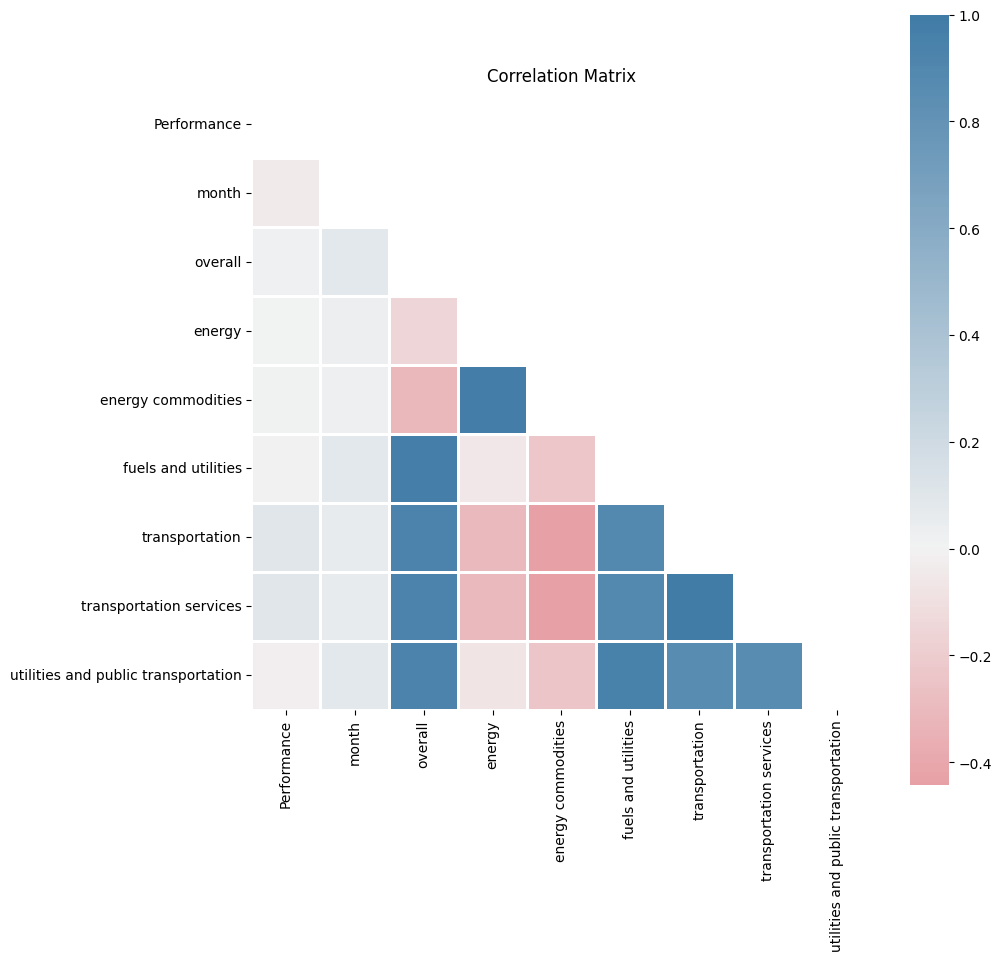

In [8]:
dd.correlation_matrix(original)

### Conditional GAN

In [9]:
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Energy (Sector),S&P 500 Performance (%),S&P 500 Energy (Sector) Performance (%),overall,energy,energy commodities,fuels and utilities,transportation,transportation services,utilities and public transportation,dow
0,12,2291.827123,481.571553,-8.880765,1.163738,250.425565,211.221226,209.101561,246.674934,323.313265,330.333421,218.034806,3
1,12,3843.564277,427.812743,-11.336011,-7.625142,244.524021,213.394859,305.183324,238.925684,323.520999,326.522775,217.404540,3
2,9,1801.386077,511.556121,-9.425240,-6.910712,226.921402,248.496823,300.110211,232.021548,285.046526,274.668902,216.758750,3
3,3,2205.194109,627.415079,-8.965075,-8.422920,231.862505,255.210221,308.550444,231.946658,279.225551,279.015399,209.978827,3
4,1,3092.459417,367.832102,-10.375134,-4.639471,258.363687,185.111030,232.088370,269.284218,315.561289,313.660632,224.297222,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,2354.482026,522.186437,-5.808634,14.786830,256.513707,207.443045,245.124710,250.216607,313.877198,321.272856,219.269851,3
9996,4,1389.829041,448.364511,7.868841,11.401399,225.761717,206.501395,243.500702,224.177423,278.661885,288.978372,212.791970,3
9997,8,2523.068821,397.563389,0.396159,5.085593,273.406299,207.001468,232.893445,249.895876,321.584860,319.326559,219.530333,3
9998,12,3472.555624,459.213295,-4.114331,-8.019088,246.553948,204.871028,234.489429,234.583920,318.634947,324.937024,216.264914,3


In [10]:
samples['Performance'] = np.where(samples['S&P 500 Energy (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)

In [11]:
samples = samples[['Performance','month', 'overall','energy','energy commodities','fuels and utilities',\
                   'transportation','transportation services','utilities and public transportation']]
samples.head()

,Performance,month,overall,energy,energy commodities,fuels and utilities,transportation,transportation services,utilities and public transportation
0,1,12,250.425565,211.221226,209.101561,246.674934,323.313265,330.333421,218.034806
1,1,12,244.524021,213.394859,305.183324,238.925684,323.520999,326.522775,217.404540
2,1,9,226.921402,248.496823,300.110211,232.021548,285.046526,274.668902,216.758750
3,1,3,231.862505,255.210221,308.550444,231.946658,279.225551,279.015399,209.978827
4,1,1,258.363687,185.111030,232.088370,269.284218,315.561289,313.660632,224.297222


In [12]:
dd.data_summary(samples)

,Info
Rows,10000
Columns,9
Size in Memory,703.2 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,1,1,0.78,0.42,2,7770
month,int64,0,0,1,6,12,6.46,3.42,12,883
overall,float64,0,0,206.55,239.31,294.39,242.29,16.18,9999,2
energy,float64,0,0,174.019,211.44,264.092,219.38,21.66,9999,2
energy commodities,float64,0,0,158.039,233.97,339.85,249.90,43.13,10000,1
fuels and utilities,float64,0,0,203.029,233.047,282.25,234.22,13.81,10000,1
transportation,float64,0,0,237.58,293.046,337.82,298.10,22.89,9999,2
transportation services,float64,0,0,238.52,289.49,338.80,295.47,23.10,10000,1
utilities and public transportation,float64,0,0,198.70,215.40,236.48,214.12,6.17,10000,1


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

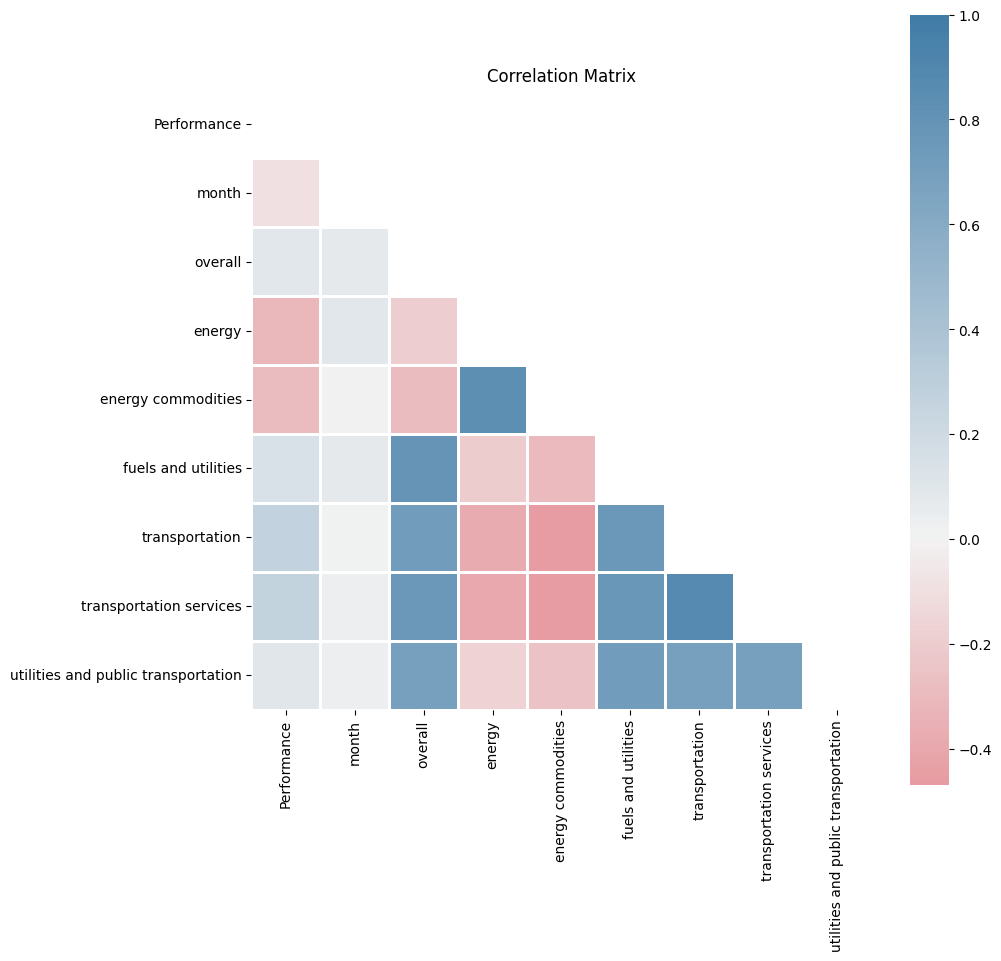

In [13]:
dd.correlation_matrix(samples)

In [14]:
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']

### SMOTE Oversampling

In [15]:
counter = Counter(y)
print(counter)
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
print(counter)

Counter({1: 7770, 0: 2230})
Counter({1: 7770, 0: 7770})


### Interaction Terms

In [16]:
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
X_poly

array([[   250.42556547,    211.22122605,    209.10156055, ...,
        106801.1771099 ,  70493.54503436,  72024.18334595],
       [   244.52402134,    213.3948595 ,    305.18332431, ...,
        105636.97455148,  70334.93408861,  70987.53378579],
       [   226.92140161,    248.49682326,    300.1102111 , ...,
         78293.41629125,  61786.3287236 ,  59536.8880239 ],
       ...,
       [   217.51293414,    247.66966272,    321.98774812, ...,
         62589.21777661,  53098.29815953,  51699.58854818],
       [   228.03410556,    196.0974502 ,    214.38915107, ...,
         78478.9884591 ,  58260.71460127,  57078.53828246],
       [   227.13630322,    241.16796282,    296.11955152, ...,
         70000.81448213,  54677.16192128,  55848.3745374 ]])

In [17]:
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X.shape

(15540, 29)

In [18]:
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
X_real.shape

(143, 29)

In [19]:
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)

### Training with CV

In [20]:
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.812227,0.914698,0.689704,0.786088,0.798456,0.892667,0.682815,0.773765,0.629371,0.790123,0.64,0.707182
1,DecisionTreeClassifier,0.79852,0.822213,0.763192,0.791238,0.783012,0.809181,0.746048,0.776333,0.622378,0.75,0.69,0.71875
2,RandomForestClassifier,0.86686,0.920376,0.804376,0.858125,0.855084,0.916567,0.784294,0.845287,0.685315,0.76699,0.79,0.778325
3,AdaBoostClassifier,0.751223,0.774748,0.708623,0.74007,0.755727,0.788813,0.704742,0.744412,0.629371,0.764045,0.68,0.719577
4,GradientBoostingClassifier,0.771236,0.802483,0.720206,0.758919,0.774517,0.820437,0.708312,0.760263,0.587413,0.759494,0.6,0.670391
5,ExtraTreesClassifier,0.890541,0.942358,0.832819,0.883903,0.874389,0.934513,0.807751,0.866521,0.636364,0.74,0.74,0.74
6,BaggingClassifier,0.837001,0.9082,0.751094,0.821761,0.825997,0.904852,0.732279,0.80947,0.643357,0.775281,0.69,0.730159
7,SVC,0.745817,0.790846,0.668983,0.724567,0.744402,0.800248,0.657828,0.722082,0.587413,0.780822,0.57,0.65896
8,GaussianNB,0.711712,0.717788,0.698198,0.707743,0.706564,0.72058,0.683835,0.701727,0.587413,0.759494,0.6,0.670391


### Voting Classifier

In [21]:
et_clf = ExtraTreesClassifier(random_state=random_state)
bag_clf = BaggingClassifier(random_state=random_state)
rf_clf = RandomForestClassifier(random_state=random_state)
classifiers = [('RF', rf_clf), \
               ('ET', et_clf),\
              ('Bagging', bag_clf)]

vc = VotingClassifier(estimators = classifiers, voting = 'soft')     
vc.fit(x_train, y_train)
y_pred = vc.predict(x_test)
vc_res = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F-1 Score'])
vc_res.loc[0, 'Accuracy'] = accuracy_score(y_test, y_pred)
vc_res.loc[0, 'Precision'] = precision_score(y_test, y_pred)
vc_res.loc[0, 'Recall'] = recall_score(y_test, y_pred)
vc_res.loc[0, 'F-1 Score'] = f1_score(y_test, y_pred)
vc_res

,Accuracy,Precision,Recall,F-1 Score
0,0.859202,0.919336,0.790413,0.850014


## Using data after 2000

In [22]:
data = pd.read_csv('../data/S&P 500 Energy 100-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2000]
data

,year,month,date,S&P 500,S&P 500 Energy (Sector),S&P 500 Performance (%),S&P 500 Energy (Sector) Performance (%),S&P 500 Energy (Sector) Outperform/Underperform,overall,energy,energy commodities,fuels and utilities,transportation,transportation services,utilities and public transportation,dow
84,2000,1,2000-01-13,1449.68,219.62,-1.473467,-3.999650,UNDERPERFORM,170.000,118.800,122.400,134.500,193.600,193.600,149.400,3
85,2000,2,2000-02-10,1416.83,196.08,-2.032872,-9.062239,UNDERPERFORM,171.000,124.300,133.400,133.600,194.400,194.400,149.800,3
86,2000,3,2000-03-09,1401.69,212.05,-2.531813,-2.532635,UNDERPERFORM,170.900,120.900,126.100,133.700,194.700,194.700,150.000,3
87,2000,4,2000-04-13,1440.51,215.82,-3.467247,-9.939910,UNDERPERFORM,171.200,120.000,124.100,133.800,195.500,195.500,150.300,3
88,2000,5,2000-05-11,1407.81,230.91,-1.307432,-5.442260,UNDERPERFORM,172.200,126.800,134.900,136.600,196.000,196.000,151.500,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,2021,7,2021-07-08,4320.82,391.55,-7.184331,-7.043825,OUTPERFORM,273.092,242.958,276.734,262.483,326.470,326.470,229.005,3
343,2021,8,2021-08-12,4460.83,375.97,-6.940799,-16.617875,UNDERPERFORM,274.214,245.847,280.047,265.333,323.329,323.329,229.123,3
344,2021,9,2021-09-09,4493.28,357.55,-1.171440,-31.339414,UNDERPERFORM,276.590,255.010,293.342,270.870,323.995,323.995,231.525,3
345,2021,10,2021-10-14,4438.26,432.43,3.749053,-23.881359,UNDERPERFORM,278.524,261.257,305.653,271.467,326.256,326.256,232.450,3


In [23]:
original = data[['S&P 500 Energy (Sector) Outperform/Underperform','month','overall','energy',\
                 'energy commodities','fuels and utilities','transportation','transportation services','utilities and public transportation']]
data.drop(columns=['date','S&P 500 Energy (Sector) Outperform/Underperform','year'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Energy (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','energy','energy commodities','fuels and utilities',\
                     'transportation','transportation services','utilities and public transportation']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Energy (Sector),S&P 500 Performance (%),S&P 500 Energy (Sector) Performance (%),overall,energy,energy commodities,fuels and utilities,transportation,transportation services,utilities and public transportation,dow
0,1,2321.666112,544.890439,-7.173862,-11.012912,249.827187,191.010416,227.124270,236.858420,307.083474,322.583018,206.576884,3
1,11,1997.664057,422.751280,-2.324504,0.534736,273.055843,204.011440,222.206489,269.102772,335.183905,323.179210,227.150192,3
2,4,971.103012,559.117862,-9.373607,-10.542214,181.251623,214.745377,236.968922,227.343504,229.230348,227.266038,210.461437,3
3,8,1003.427666,214.034063,-8.172041,-11.998295,178.927666,118.968648,145.195491,150.840700,205.940805,226.800322,162.150449,3
4,7,1410.995877,570.084033,36.555795,11.865389,242.159226,274.274443,334.314307,235.629306,275.730967,263.559302,205.690227,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,10,1000.855088,509.956579,-7.644697,-5.438656,211.640848,205.566159,172.169207,146.204903,217.380582,215.030644,165.059375,3
9996,7,1225.937483,222.170331,1.005562,-5.627916,181.685245,136.754964,173.416558,167.417600,220.457264,225.766566,159.300225,3
9997,2,2501.926580,583.432645,-5.276848,-15.728680,228.651532,236.002089,219.989870,231.412734,300.934791,292.093328,221.770681,3
9998,6,1226.030869,223.420595,-1.372770,3.449026,207.771100,195.782540,167.716409,150.309465,210.911949,224.204505,165.988573,3


In [24]:
samples['Performance'] = np.where(samples['S&P 500 Energy (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month', 'overall','energy','energy commodities','fuels and utilities',\
                   'transportation','transportation services','utilities and public transportation']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.684392,0.653852,0.77798,0.709728,0.66468,0.630469,0.764706,0.69113,0.642586,0.676692,0.638298,0.656934
1,DecisionTreeClassifier,0.668706,0.658818,0.69453,0.675006,0.662484,0.646459,0.688619,0.666873,0.631179,0.652778,0.666667,0.659649
2,RandomForestClassifier,0.76502,0.752166,0.78564,0.765712,0.728984,0.709581,0.757673,0.732839,0.608365,0.672727,0.524823,0.589641
3,AdaBoostClassifier,0.661961,0.660622,0.665699,0.662787,0.671267,0.663291,0.670077,0.666667,0.627376,0.674797,0.588652,0.628788
4,GradientBoostingClassifier,0.674824,0.667494,0.695972,0.680974,0.671895,0.650757,0.714834,0.681292,0.596958,0.62963,0.602837,0.615942
5,ExtraTreesClassifier,0.788863,0.777376,0.805244,0.787625,0.757842,0.741169,0.778133,0.759201,0.627376,0.721649,0.496454,0.588235
6,BaggingClassifier,0.722431,0.731313,0.696706,0.711335,0.702321,0.705411,0.675192,0.689971,0.653992,0.723214,0.574468,0.640316
7,SVC,0.65702,0.66016,0.646886,0.653154,0.651506,0.642006,0.654731,0.648306,0.631179,0.664179,0.631206,0.647273
8,GaussianNB,0.578196,0.561107,0.717643,0.629741,0.582811,0.557749,0.722506,0.629526,0.69962,0.69375,0.787234,0.737542


## Using all data

In [25]:
data = pd.read_csv('../data/S&P 500 Energy 100-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data

,year,month,date,S&P 500,S&P 500 Energy (Sector),S&P 500 Performance (%),S&P 500 Energy (Sector) Performance (%),S&P 500 Energy (Sector) Outperform/Underperform,overall,energy,energy commodities,fuels and utilities,transportation,transportation services,utilities and public transportation,dow
0,1993,1,1993-01-14,435.94,89.26,-1.972072,-14.321367,UNDERPERFORM,143.100,104.300,100.500,118.900,160.800,160.800,131.800,3
1,1993,2,1993-02-11,447.66,95.06,1.090712,-4.586972,UNDERPERFORM,143.300,104.900,99.900,120.300,160.500,160.500,132.500,3
2,1993,3,1993-03-11,453.72,96.61,0.990496,-5.525132,UNDERPERFORM,143.800,104.900,99.400,120.700,161.000,161.000,133.100,3
3,1993,4,1993-04-08,441.84,102.81,-4.685478,-2.917847,OUTPERFORM,144.200,104.300,97.500,121.100,162.300,162.300,134.200,3
4,1993,5,1993-05-13,439.23,101.48,-4.763660,-5.309322,UNDERPERFORM,144.300,103.900,96.400,121.400,162.600,162.600,134.700,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,2021,7,2021-07-08,4320.82,391.55,-7.184331,-7.043825,OUTPERFORM,273.092,242.958,276.734,262.483,326.470,326.470,229.005,3
343,2021,8,2021-08-12,4460.83,375.97,-6.940799,-16.617875,UNDERPERFORM,274.214,245.847,280.047,265.333,323.329,323.329,229.123,3
344,2021,9,2021-09-09,4493.28,357.55,-1.171440,-31.339414,UNDERPERFORM,276.590,255.010,293.342,270.870,323.995,323.995,231.525,3
345,2021,10,2021-10-14,4438.26,432.43,3.749053,-23.881359,UNDERPERFORM,278.524,261.257,305.653,271.467,326.256,326.256,232.450,3


In [26]:
original = data[['S&P 500 Energy (Sector) Outperform/Underperform','month','overall','energy',\
                 'energy commodities','fuels and utilities','transportation','transportation services','utilities and public transportation']]
data.drop(columns=['date','S&P 500 Energy (Sector) Outperform/Underperform','year'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Energy (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','energy','energy commodities','fuels and utilities',\
                     'transportation','transportation services','utilities and public transportation']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Energy (Sector),S&P 500 Performance (%),S&P 500 Energy (Sector) Performance (%),overall,energy,energy commodities,fuels and utilities,transportation,transportation services,utilities and public transportation,dow
0,1,1762.550679,480.104649,-9.742153,-10.541436,239.274733,220.279787,178.599579,188.920076,313.710896,251.887259,198.051140,3
1,7,4766.477047,406.440108,-9.142080,-9.944176,282.107919,241.732140,238.353214,267.386960,346.714508,345.419911,233.379433,3
2,6,835.396482,212.962986,13.869542,25.387628,175.071567,110.399695,117.251126,128.290899,200.776172,204.535271,145.962731,3
3,4,1798.031788,427.459741,3.534248,9.909086,223.461403,169.098565,172.580745,177.298457,227.958214,253.351408,210.056534,3
4,10,1281.572761,233.986751,-7.460860,-9.218295,171.744039,226.609452,119.069093,127.188952,223.079514,226.138269,135.250812,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,7,2559.593736,533.462337,-9.699820,3.985625,283.212533,209.158432,208.308943,251.064115,332.964051,332.594401,233.030266,3
9996,8,1295.961976,144.917040,-3.479383,-4.374637,167.984270,122.172027,137.201433,149.473185,190.821081,233.751637,169.807748,3
9997,7,1220.713036,315.920277,0.650356,4.065176,167.795108,140.744037,123.361158,133.590364,244.898039,203.252963,156.290573,3
9998,7,1241.516898,206.886247,3.173508,1.711816,174.311018,126.164302,121.473255,137.643190,216.553253,237.226282,160.080741,3


In [27]:
samples['Performance'] = np.where(samples['S&P 500 Energy (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month', 'overall','energy','energy commodities','fuels and utilities',\
                   'transportation','transportation services','utilities and public transportation']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.712773,0.772683,0.608319,0.680024,0.696303,0.745455,0.613296,0.672948,0.564841,0.607843,0.635897,0.621554
1,DecisionTreeClassifier,0.708963,0.730319,0.667609,0.696931,0.692069,0.709016,0.670914,0.689439,0.605187,0.616,0.789744,0.692135
2,RandomForestClassifier,0.798941,0.852107,0.729432,0.784737,0.764324,0.802747,0.712465,0.754916,0.610951,0.640187,0.702564,0.669927
3,AdaBoostClassifier,0.660762,0.705364,0.552575,0.619553,0.653119,0.703966,0.550693,0.617967,0.599424,0.694444,0.512821,0.589971
4,GradientBoostingClassifier,0.672054,0.701435,0.599716,0.646517,0.663844,0.69832,0.598892,0.644796,0.619597,0.711409,0.54359,0.616279
5,ExtraTreesClassifier,0.835568,0.884775,0.776432,0.825992,0.797065,0.833129,0.752355,0.790684,0.585014,0.605809,0.748718,0.669725
6,BaggingClassifier,0.748906,0.821701,0.639665,0.718566,0.725938,0.785226,0.636011,0.702785,0.636888,0.663507,0.717949,0.689655
7,SVC,0.650529,0.663014,0.612562,0.63674,0.648885,0.666469,0.622161,0.643553,0.659942,0.717514,0.651282,0.682796
8,GaussianNB,0.58885,0.634018,0.421313,0.506134,0.583122,0.629952,0.440443,0.518422,0.613833,0.732824,0.492308,0.588957
